In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import pi
from matplotlib import rc
plt.style.reload_library()
plt.style.use(['science', 'grid'])
from scipy.odr import ODR, Model, Data, RealData
import scipy.optimize as opt; #allows for curve fitting
from scipy.odr import *

In [27]:
# DEFINING FITTING FUNCTIONS
def Interference_double(parameters, x): # [a, d, lambda]
    beta = (pi*parameters[1]/656e-9)*np.sin(x)
    alpha = (pi*parameters[0]/656e-9)*np.sin(x)
    return (np.cos(beta)**2)*(np.sin(alpha)/alpha)**2

def Interference_single(parameters,x): # [a, lambda]
    alpha = (pi*parameters[0]/(656e-9))*np.sin(x)
    return (np.sin(alpha)/alpha)**2

def PlotODR(xdata,ydata,error_x,error_y,function,output,color,x_label,y_label,low_limit, up_limit):
    fig = plt.figure(figsize=(5, 5), dpi=80)
    plt.errorbar(xdata,ydata,yerr=error_y,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    plt.errorbar(xdata,ydata,xerr=error_x,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    
    title = r'$\textbf{' + y_label + ' vs ' + x_label + '}$'
    x = np.linspace(low_limit, up_limit, 500)
    plt.plot(x,function(output.beta, x),color=color)
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.savefig("Figures/figure.png")

def arctanfunc(x):
    return np.arctan(x)[0]

# DEFINING A FUNCTION THAT RETURNS THE UNCERTAINTY USING VARIATIONAL METHOD
def uncertainty_var(values, deltas, function):
    values, deltas = np.array(values), np.array(deltas)
    delta_matrix = deltas*np.identity(values.shape[0])
    sum = 0
    for delta in delta_matrix:
        sum += (0.5*(abs(function(values + delta) - function(values)) + abs(function(values-delta) - function(values))))**2
    return np.sqrt(sum)

# DEFINING A FUNCTION THAT RETURNS THE WEIGHTED AVERAGE WITH UNCERTAINTY
def weighted_avgs(values, deltas):
    weights = np.array(list(map(lambda x : 1/x**2, deltas)))
    best_val = np.dot(np.array(values), weights)/weights.sum()
    uncert = 1/np.sqrt(weights.sum())
    return [best_val, uncert]

## Back Slit

In [3]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1iYbA_X-BAgKxj-p5xsn6TMuqubb39IdXJCk7EbgtABg'
workSheetName = 'Back_Slit'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :8]
df['Error theta'] = df.apply(lambda x: uncertainty_var([x['Position - offset (mm)']/500], [x['Uncert_Position']/500], arctanfunc), axis=1)
df

,Intensity (Volts),Intensity - offset (Volts),Uncert_Intensity,Position (mm),Position - offset (mm),Uncert_Position,Normalized Intensity,Theta (rad),Error theta
0,0.336,0.328,0.001,4.57,-0.18,0.01,1.000000,-0.00036,0.00002
1,0.335,0.327,0.001,5.01,0.26,0.01,0.996951,0.00052,0.00002
2,0.327,0.319,0.001,4.41,-0.34,0.01,0.972561,-0.00068,0.00002
3,0.321,0.313,0.001,5.25,0.50,0.01,0.954268,0.00100,0.00002
4,0.311,0.303,0.001,5.41,0.66,0.01,0.923780,0.00132,0.00002
5,0.309,0.301,0.001,4.20,-0.55,0.01,0.917683,-0.00110,0.00002
6,0.289,0.281,0.001,4.02,-0.73,0.01,0.856707,-0.00146,0.00002
7,0.270,0.262,0.001,5.75,1.00,0.01,0.798780,0.00200,0.00002
8,0.264,0.256,0.001,3.80,-0.95,0.01,0.780488,-0.00190,0.00002
9,0.242,0.234,0.001,5.95,1.20,0.01,0.713415,0.00240,0.00002


a = ( 0.08920571468876103  ±  0.0006040827693182217 ) mm
[8.92057147e-05]
Percentage error:  4.947899633836494 %
Experimental precision: 0.6771794513679623 %
Sigmas: 7.306629910050135


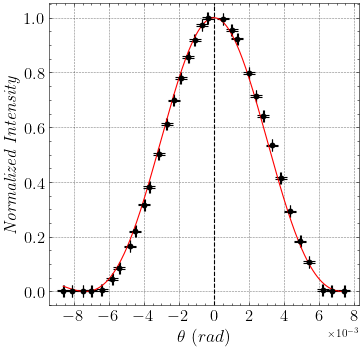

In [4]:
model = Model(Interference_single)
xdata, ydata, error_x, error_y = df['Theta (rad)'], df['Normalized Intensity'], df['Error theta'], df['Uncert_Intensity']/(df['Intensity (Volts)'].max())
x_min, x_max = df['Theta (rad)'].min(), df['Theta (rad)'].max()
data = RealData(xdata, ydata, error_x, error_y)
odr = ODR(data, model, [0.085e-3])
odr.set_job(fit_type=2) #Ordinary least squeares
output = odr.run()
a, da = output.beta[0]*1e3, output.sd_beta[0]*1e3
PlotODR(xdata, ydata, error_x, error_y, Interference_single, output,'Red',r'$\theta \ (rad)$', 'Normalized Intensity',x_min, x_max)
a_nominal = 0.085
units = 'mm'
print('a = (', a, ' ± ', da, ') mm')
print(output.beta)
# DETERMING THE %ERROR
error = abs((a-a_nominal)/a_nominal)*100
print("Percentage error: ", error, "%")
exp_precision = 100*da/a
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

## Front Slit

In [5]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1iYbA_X-BAgKxj-p5xsn6TMuqubb39IdXJCk7EbgtABg'
workSheetName = 'Front_Slit'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :8]
df['Error theta'] = df.apply(lambda x: uncertainty_var([x['Position - offset (mm)']/500], [x['Uncert_Position']/500], arctanfunc), axis=1)
df

,Intensity (Volts),Intensity - offset (Volts),Uncert_Intensity,Position (mm),Position - offset (mm),Uncert_Position,Normalized Intensity,Theta (rad),Error theta
0,0.329,0.321,0.001,3.85,0.33,0.01,1.000000,0.00066,0.00002
1,0.327,0.319,0.001,3.29,-0.23,0.01,0.993769,-0.00046,0.00002
2,0.318,0.310,0.001,4.05,0.53,0.01,0.965732,0.00106,0.00002
3,0.309,0.301,0.001,3.07,-0.45,0.01,0.937695,-0.00090,0.00002
4,0.293,0.285,0.001,4.36,0.84,0.01,0.887850,0.00168,0.00002
5,0.270,0.262,0.001,2.75,-0.77,0.01,0.816199,-0.00154,0.00002
6,0.248,0.240,0.001,4.71,1.19,0.01,0.747664,0.00238,0.00002
7,0.229,0.221,0.001,2.49,-1.03,0.01,0.688474,-0.00206,0.00002
8,0.205,0.197,0.001,4.98,1.46,0.01,0.613707,0.00292,0.00002
9,0.195,0.187,0.001,2.27,-1.25,0.01,0.582555,-0.00250,0.00002


a = ( 0.09397176436272954  ±  0.0013585509631890858 ) mm
Percentage error:  10.555016897328864 %
Experimental precision: 1.445701240582331 %
Sigmas: 7.300966894845635


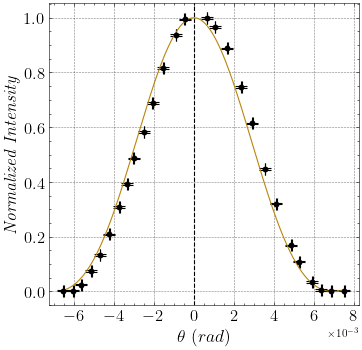

In [6]:
model = Model(Interference_single)
xdata, ydata, error_x, error_y = df['Theta (rad)'], df['Normalized Intensity'], df['Error theta'], df['Uncert_Intensity']/(df['Intensity (Volts)'].max())
x_min, x_max = df['Theta (rad)'].min(), df['Theta (rad)'].max()
data = RealData(xdata, ydata, error_x, error_y)
odr = ODR(data, model, [0.085e-3])
odr.set_job(fit_type=2) #Ordinary least squeares
output = odr.run()
a, da = output.beta[0]*1e3, output.sd_beta[0]*1e3
PlotODR(xdata, ydata, error_x, error_y, Interference_single, output,'darkgoldenrod',r'$\theta \ (rad)$', 'Normalized Intensity',x_min, x_max)
a_nominal = 0.085
units = 'mm'
print('a = (', a, ' ± ', da, ') mm')

# DETERMING THE %ERROR
error = abs((a-a_nominal)/a_nominal)*100
print("Percentage error: ", error, "%")
exp_precision = 100*da/a
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

## Double Slit

In [24]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1iYbA_X-BAgKxj-p5xsn6TMuqubb39IdXJCk7EbgtABg'
workSheetName = 'Week1_Double_Slit'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :8]
df

,Intensity (Volts),Intensity - offset (Volts),Uncert_Intensity,Position (mm),Position - offset (mm),Uncert_Position,Normalized Intensity,Theta (rad)
0,0.074,0.066,0.001,1.50,-2.70,0.01,0.060329,-0.0054
1,0.063,0.055,0.001,1.55,-2.65,0.01,0.050274,-0.0053
2,0.058,0.050,0.001,1.60,-2.60,0.01,0.045704,-0.0052
3,0.061,0.053,0.001,1.65,-2.55,0.01,0.048446,-0.0051
4,0.074,0.066,0.001,1.70,-2.50,0.01,0.060329,-0.0050
...,...,...,...,...,...,...,...,...
104,0.086,0.078,0.001,6.80,2.60,0.01,0.071298,0.0052
105,0.085,0.077,0.001,6.85,2.65,0.01,0.070384,0.0053
106,0.088,0.080,0.001,6.90,2.70,0.01,0.073126,0.0054
107,0.092,0.084,0.001,6.95,2.75,0.01,0.076782,0.0055


In [25]:
df['Error theta'] = df.apply(lambda x: uncertainty_var([x['Position - offset (mm)']/500], [x['Uncert_Position']/500], arctanfunc), axis=1)

a = ( 0.08283924341010356  ±  0.0012266092957390678 ) mm
Percentage error:  2.5420665763487658 %
Experimental precision: 1.480710403964727 %
Sigmas: 1.716788488513465
d = ( 0.4430616673752786  ±  0.0010806430725946623 ) mm
Percentage error:  26.58904782150817 %
Experimental precision: 0.2439035358207472 %
Sigmas: 109.01460584421106


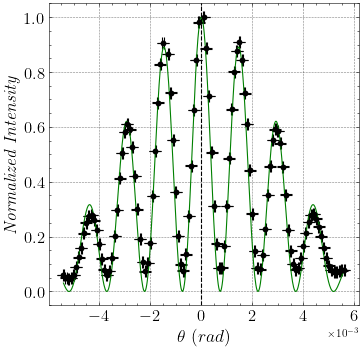

In [29]:
model = Model(Interference_double)
xdata, ydata, error_x, error_y = df['Theta (rad)'], df['Normalized Intensity'], df['Error theta'], df['Uncert_Intensity']/(df['Intensity (Volts)'].max())
x_min, x_max = df['Theta (rad)'].min(), df['Theta (rad)'].max()
data = RealData(xdata, ydata, error_x, error_y)
odr = ODR(data, model, [0.085e-3, 0.35e-3])
odr.set_job(fit_type=2) #Ordinary least squeares
output = odr.run()
a, da = output.beta[0]*1e3, output.sd_beta[0]*1e3
d, dd = output.beta[1]*1e3, output.sd_beta[1]*1e3
PlotODR(xdata, ydata, error_x, error_y, Interference_double, output,'green',r'$\theta \ (rad)$', 'Normalized Intensity',x_min, x_max)
a_nominal = 0.085
units = 'mm'
print('a = (', a, ' ± ', da, ') mm')

# DETERMING THE %ERROR
error = abs((a-a_nominal)/a_nominal)*100
print("Percentage error: ", error, "%")
exp_precision = 100*da/a
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

d_nominal = 0.35
units = 'mm'
print('d = (', d, ' ± ', dd, ') mm')

# DETERMING THE %ERROR
error = abs((d-d_nominal)/d_nominal)*100
print("Percentage error: ", error, "%")
exp_precision = 100*dd/d
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

In [30]:
# FINDING a USING WEIGHTED AVERAGES
wa = weighted_avgs([0.08920571468876103, 0.09397176436272954, 0.08283924226541929], [0.0006040827693182217, 0.0013585509631890858, 0.0012266099944401008])
a, da = wa[0], wa[1]
print('a = (', a, ' ± ', da, ') mm')

# DETERMING THE %ERROR
error = abs((a-a_nominal)/a_nominal)*100
print("Percentage error: ", error, "%")
exp_precision = 100*da/a
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

a = ( 0.08878787906672088  ±  0.0005033579687040875 ) mm
Percentage error:  4.456328313789261 %
Experimental precision: 0.5669219424937858 %
Sigmas: 7.8605677074108105
